In [2]:
import scanpy as sc
import pandas as pd
import os
from pathlib import Path

# ========== CONFIGURE PATHS ==========
# Base directory where your mapped samples are
base_dir = Path("/rds/general/user/pr422/projects/puklandmarkproject/ephemeral/alex/mapping_outs")

# Output directory for saving converted h5ad files
output_dir = Path("/rds/general/user/pr422/projects/puklandmarkproject/ephemeral/Parisa_scdownstream/scdown_old_samples/h5ad_converted")
output_dir.mkdir(parents=True, exist_ok=True)

# Path to save the samplesheet CSV
samplesheet_path = Path("/rds/general/user/pr422/projects/puklandmarkproject/ephemeral/Parisa_scdownstream/scdown_old_samples/input/samplesheet_converted_remapped_h5ad_epilep.csv")
samplesheet_path.parent.mkdir(parents=True, exist_ok=True)

# ========== START PROCESSING ==========

samples = [d for d in base_dir.iterdir() if d.is_dir() and d.name.endswith("_mapped")]
samples = sorted(samples)

records = []

for sample_path in samples:
    sample_id = sample_path.name.replace("_mapped", "")
    outs_path = sample_path / "outs"
    
    filtered_matrix_dir = outs_path / "filtered_feature_bc_matrix"
    raw_matrix_dir = outs_path / "raw_feature_bc_matrix"

    if not filtered_matrix_dir.exists() or not raw_matrix_dir.exists():
        print(f"Warning: Missing filtered or raw matrix for sample {sample_id}")
        continue

    # --------- Convert filtered
    filtered_adata = sc.read_10x_mtx(
        str(filtered_matrix_dir),
        var_names="gene_symbols",
        cache=False
    )
    filtered_outfile = output_dir / f"{sample_id}_filtered.h5ad"
    filtered_adata.write_h5ad(str(filtered_outfile))

    # --------- Convert raw
    raw_adata = sc.read_10x_mtx(
        str(raw_matrix_dir),
        var_names="gene_symbols",
        cache=False
    )
    raw_outfile = output_dir / f"{sample_id}_raw.h5ad"
    raw_adata.write_h5ad(str(raw_outfile))

    # --------- Save to records
    records.append({
        "sample": sample_id,
        "filtered": str(filtered_outfile),
        "unfiltered": str(raw_outfile)
    })

# ========== WRITE SAMPLE SHEET ==========

samplesheet_df = pd.DataFrame(records, columns=["sample", "filtered", "unfiltered"])
samplesheet_df.to_csv(samplesheet_path, index=False)

print(f"\n✅ Done! Converted {len(records)} samples.")
print(f"✅ Samplesheet saved at: {samplesheet_path}")


✅ Done! Converted 32 samples.
✅ Samplesheet saved at: /rds/general/user/pr422/projects/puklandmarkproject/ephemeral/Parisa_scdownstream/scdown_old_samples/input/samplesheet_converted_remapped_h5ad_epilep.csv


In [1]:
import scanpy as sc

# Load filtered
filtered = sc.read_h5ad("/rds/general/user/pr422/ephemeral/NEXTFLOW/86/d31d70dcec37754f78089436649d87/S16B_filtered_unified.h5ad")

# Load unfiltered
unfiltered = sc.read_h5ad("/rds/general/user/pr422/ephemeral/NEXTFLOW/e0/53d3275d8a9323ef197a0a12ffe5d0/S16B_unfiltered_unified.h5ad")

# Check dimensions
print(filtered.shape, unfiltered.shape)

# Check gene names match exactly
print(filtered.var_names.equals(unfiltered.var_names))

# Check cells/barcodes (should differ by filtering)
print(filtered.obs_names[:5])
print(unfiltered.obs_names[:5])

# Verify metadata columns
print(filtered.obs.head())
print(unfiltered.obs.head())


(33244, 38606) (3694957, 38606)
True
Index(['S16B_AAACCCAAGATCCGAG-1', 'S16B_AAACCCAAGCCGGATA-1',
       'S16B_AAACCCAAGCTCGGCT-1', 'S16B_AAACCCAAGCTCTATG-1',
       'S16B_AAACCCAAGGTCTTTG-1'],
      dtype='object')
Index(['S16B_AAACCCAAGAAACACT-1', 'S16B_AAACCCAAGAAACCAT-1',
       'S16B_AAACCCAAGAAACCCA-1', 'S16B_AAACCCAAGAAACCCG-1',
       'S16B_AAACCCAAGAAACTAC-1'],
      dtype='object')
                        batch    label sample
S16B_AAACCCAAGATCCGAG-1  S16B  unknown   S16B
S16B_AAACCCAAGCCGGATA-1  S16B  unknown   S16B
S16B_AAACCCAAGCTCGGCT-1  S16B  unknown   S16B
S16B_AAACCCAAGCTCTATG-1  S16B  unknown   S16B
S16B_AAACCCAAGGTCTTTG-1  S16B  unknown   S16B
                        batch    label sample
S16B_AAACCCAAGAAACACT-1  S16B  unknown   S16B
S16B_AAACCCAAGAAACCAT-1  S16B  unknown   S16B
S16B_AAACCCAAGAAACCCA-1  S16B  unknown   S16B
S16B_AAACCCAAGAAACCCG-1  S16B  unknown   S16B
S16B_AAACCCAAGAAACTAC-1  S16B  unknown   S16B


In [3]:
import pandas as pd
samplesheet = pd.read_csv("/rds/general/user/pr422/projects/puklandmarkproject/ephemeral/Parisa_scdownstream/scdown_old_samples/input/samplesheet_converted_remapped_h5ad_epilep.csv")
print(samplesheet.head())

# Check that paths exist and match sample IDs
for idx, row in samplesheet.iterrows():
    assert row["sample"] in row["filtered"], f"Filtered mismatch: {row['sample']}"
    assert row["sample"] in row["unfiltered"], f"Unfiltered mismatch: {row['sample']}"

  sample                                           filtered  \
0   S10A  /rds/general/user/pr422/projects/puklandmarkpr...   
1   S11A  /rds/general/user/pr422/projects/puklandmarkpr...   
2   S11B  /rds/general/user/pr422/projects/puklandmarkpr...   
3   S12B  /rds/general/user/pr422/projects/puklandmarkpr...   
4   S13A  /rds/general/user/pr422/projects/puklandmarkpr...   

                                          unfiltered  
0  /rds/general/user/pr422/projects/puklandmarkpr...  
1  /rds/general/user/pr422/projects/puklandmarkpr...  
2  /rds/general/user/pr422/projects/puklandmarkpr...  
3  /rds/general/user/pr422/projects/puklandmarkpr...  
4  /rds/general/user/pr422/projects/puklandmarkpr...  


In [5]:
import scanpy as sc
import pandas as pd
import os

samplesheet = pd.read_csv("/rds/general/user/pr422/projects/puklandmarkproject/ephemeral/Parisa_scdownstream/scdown_old_samples/input/samplesheet_converted_remapped_h5ad_epilep.csv")

for idx, row in samplesheet.iterrows():
    for path_type in ['filtered', 'unfiltered']:
        path = row[path_type]
        sample = row['sample']
        if not os.path.exists(path):
            print(f"❌ {path_type} file for {sample} does NOT exist: {path}")
            continue
        try:
            adata = sc.read_h5ad(path)
            print(f"✅ {path_type} file for {sample} loaded successfully. Shape: {adata.shape}")
        except Exception as e:
            print(f"❌ {path_type} file for {sample} failed to load: {path}, Error: {e}")

✅ filtered file for S10A loaded successfully. Shape: (23600, 38606)
✅ unfiltered file for S10A loaded successfully. Shape: (3933123, 38606)
✅ filtered file for S11A loaded successfully. Shape: (25165, 38606)
✅ unfiltered file for S11A loaded successfully. Shape: (3904139, 38606)
✅ filtered file for S11B loaded successfully. Shape: (21620, 38606)
✅ unfiltered file for S11B loaded successfully. Shape: (3192095, 38606)
✅ filtered file for S12B loaded successfully. Shape: (23715, 38606)
✅ unfiltered file for S12B loaded successfully. Shape: (3325816, 38606)
✅ filtered file for S13A loaded successfully. Shape: (20068, 38606)
✅ unfiltered file for S13A loaded successfully. Shape: (3509689, 38606)
✅ filtered file for S13B loaded successfully. Shape: (29992, 38606)
✅ unfiltered file for S13B loaded successfully. Shape: (4048065, 38606)
✅ filtered file for S14A loaded successfully. Shape: (19362, 38606)
✅ unfiltered file for S14A loaded successfully. Shape: (3644569, 38606)
✅ filtered file for 

In [6]:
import scanpy as sc

filtered = sc.read_h5ad("/rds/general/user/pr422/projects/puklandmarkproject/ephemeral/Parisa_scdownstream/scdown_old_samples/h5ad_converted/S16B_filtered.h5ad")
unfiltered = sc.read_h5ad("/rds/general/user/pr422/projects/puklandmarkproject/ephemeral/Parisa_scdownstream/scdown_old_samples/h5ad_converted/S16B_raw.h5ad")

print("Filtered barcodes (first 5):", filtered.obs_names[:5])
print("Unfiltered barcodes (first 5):", unfiltered.obs_names[:5])

# Check intersection explicitly
print("Common barcodes:", len(set(filtered.obs_names) & set(unfiltered.obs_names)))

Filtered barcodes (first 5): Index(['AAACCCAAGATCCGAG-1', 'AAACCCAAGCCGGATA-1', 'AAACCCAAGCTCGGCT-1',
       'AAACCCAAGCTCTATG-1', 'AAACCCAAGGTCTTTG-1'],
      dtype='object')
Unfiltered barcodes (first 5): Index(['AAACCCAAGAAACACT-1', 'AAACCCAAGAAACCAT-1', 'AAACCCAAGAAACCCA-1',
       'AAACCCAAGAAACCCG-1', 'AAACCCAAGAAACTAC-1'],
      dtype='object')
Common barcodes: 33244


In [7]:
import scanpy as sc

filtered = sc.read_h5ad("/rds/general/user/pr422/projects/puklandmarkproject/ephemeral/Parisa_scdownstream/scdown_old_samples/h5ad_converted/S2A_filtered.h5ad")
unfiltered = sc.read_h5ad("/rds/general/user/pr422/projects/puklandmarkproject/ephemeral/Parisa_scdownstream/scdown_old_samples/h5ad_converted/S2A_raw.h5ad")

print("Filtered barcodes (first 5):", filtered.obs_names[:5])
print("Unfiltered barcodes (first 5):", unfiltered.obs_names[:5])

# Check intersection explicitly
print("Common barcodes:", len(set(filtered.obs_names) & set(unfiltered.obs_names)))

Filtered barcodes (first 5): Index(['AAACCCAAGAAGCCAC-1', 'AAACCCAAGACAGTCG-1', 'AAACCCAAGACGCCCT-1',
       'AAACCCAAGAGTATAC-1', 'AAACCCAAGCCTTGAT-1'],
      dtype='object')
Unfiltered barcodes (first 5): Index(['AAACCCAAGAAACACT-1', 'AAACCCAAGAAACCAT-1', 'AAACCCAAGAAACCCA-1',
       'AAACCCAAGAAACCTG-1', 'AAACCCAAGAAACTAC-1'],
      dtype='object')
Common barcodes: 36671


In [8]:
import scanpy as sc

# Convert filtered data
adata_filtered = sc.read_10x_mtx(
    "/rds/general/user/pr422/projects/puklandmarkproject/ephemeral/alex/mapping_outs/S16B_mapped/outs/filtered_feature_bc_matrix",
    var_names='gene_symbols',
    cache=False
)
adata_filtered.write_h5ad("/rds/general/user/pr422/projects/puklandmarkproject/ephemeral/Parisa_scdownstream/scdown_old_samples/test_h5ad_files/S16B_filtered.h5ad")

# Convert unfiltered data
adata_unfiltered = sc.read_10x_mtx(
    "/rds/general/user/pr422/projects/puklandmarkproject/ephemeral/alex/mapping_outs/S16B_mapped/outs/raw_feature_bc_matrix",
    var_names='gene_symbols',
    cache=False
)
adata_unfiltered.write_h5ad("/rds/general/user/pr422/projects/puklandmarkproject/ephemeral/Parisa_scdownstream/scdown_old_samples/test_h5ad_files/S16B_raw.h5ad")

In [9]:
import scanpy as sc

filtered = sc.read_h5ad("//rds/general/user/pr422/projects/puklandmarkproject/ephemeral/Parisa_scdownstream/scdown_old_samples/test_h5ad_files/S16B_filtered.h5ad")
unfiltered = sc.read_h5ad("/rds/general/user/pr422/projects/puklandmarkproject/ephemeral/Parisa_scdownstream/scdown_old_samples/test_h5ad_files/S16B_raw.h5ad")

print("Filtered barcodes (first 5):", filtered.obs_names[:5])
print("Unfiltered barcodes (first 5):", unfiltered.obs_names[:5])

# Check intersection explicitly
print("Common barcodes:", len(set(filtered.obs_names) & set(unfiltered.obs_names)))

Filtered barcodes (first 5): Index(['AAACCCAAGATCCGAG-1', 'AAACCCAAGCCGGATA-1', 'AAACCCAAGCTCGGCT-1',
       'AAACCCAAGCTCTATG-1', 'AAACCCAAGGTCTTTG-1'],
      dtype='object')
Unfiltered barcodes (first 5): Index(['AAACCCAAGAAACACT-1', 'AAACCCAAGAAACCAT-1', 'AAACCCAAGAAACCCA-1',
       'AAACCCAAGAAACCCG-1', 'AAACCCAAGAAACTAC-1'],
      dtype='object')
Common barcodes: 33244


In [1]:
import scanpy as sc
import pandas as pd
import os

# Directory containing the mapped samples
input_dir = "/rds/general/user/pr422/projects/puklandmarkproject/ephemeral/alex/mapping_outs"

# Output directory for h5ad files
output_dir = "/rds/general/user/pr422/projects/puklandmarkproject/ephemeral/Parisa_scdownstream/scdown_old_samples/h5ad_converted"
os.makedirs(output_dir, exist_ok=True)

samples = [s for s in os.listdir(input_dir) if s.endswith('_mapped')]

# Container for samplesheet entries
samplesheet_entries = []

for sample in samples:
    sample_id = sample.replace("_mapped", "")

    # Paths to filtered and raw feature matrices
    filtered_path = os.path.join(input_dir, sample, "outs", "filtered_feature_bc_matrix")
    raw_path = os.path.join(input_dir, sample, "outs", "raw_feature_bc_matrix")

    # Read filtered data
    adata_filtered = sc.read_10x_mtx(filtered_path, var_names="gene_symbols", cache=False)
    adata_filtered.obs_names = [f"{sample_id}_{bc}" for bc in adata_filtered.obs_names]
    adata_filtered.obs["sample"] = sample_id

    # Save filtered h5ad
    filtered_h5ad_path = os.path.join(output_dir, f"{sample_id}_filtered.h5ad")
    adata_filtered.write(filtered_h5ad_path)

    # Read raw data
    adata_raw = sc.read_10x_mtx(raw_path, var_names="gene_symbols", cache=False)
    adata_raw.obs_names = [f"{sample_id}_{bc}" for bc in adata_raw.obs_names]
    adata_raw.obs["sample"] = sample_id

    # Save raw h5ad
    raw_h5ad_path = os.path.join(output_dir, f"{sample_id}_raw.h5ad")
    adata_raw.write(raw_h5ad_path)

    # Add to samplesheet
    samplesheet_entries.append({
        "sample": sample_id,
        "filtered": filtered_h5ad_path,
        "unfiltered": raw_h5ad_path
    })

# Create and save samplesheet
samplesheet = pd.DataFrame(samplesheet_entries)
samplesheet.to_csv(os.path.join(output_dir, "samplesheet_converted.csv"), index=False)

print("Done! Samplesheet saved at:", os.path.join(output_dir, "samplesheet_corrected.csv"))


Done! Samplesheet saved at: /rds/general/user/pr422/projects/puklandmarkproject/ephemeral/Parisa_scdownstream/scdown_old_samples/h5ad_converted/samplesheet_corrected.csv


In [2]:
import scanpy as sc
import pandas as pd
import os

samplesheet = "/rds/general/user/pr422/projects/puklandmarkproject/ephemeral/Parisa_scdownstream/scdown_old_samples/h5ad_converted/samplesheet_converted.csv"

# Load samplesheet
df = pd.read_csv(samplesheet)

all_good = True

for i, row in df.iterrows():
    sample = row['sample']
    filtered_path = row['filtered']
    unfiltered_path = row['unfiltered']

    print(f"\nChecking {sample}:")

    adata_filtered = sc.read_h5ad(filtered_path)
    adata_unfiltered = sc.read_h5ad(unfiltered_path)

    filtered_barcodes = set(adata_filtered.obs_names)
    unfiltered_barcodes = set(adata_unfiltered.obs_names)

    # Check barcodes match
    common_barcodes = filtered_barcodes & unfiltered_barcodes
    missing_barcodes = filtered_barcodes - unfiltered_barcodes

    if len(missing_barcodes) == 0:
        print(f"✅ All {len(filtered_barcodes)} filtered barcodes are present in the unfiltered dataset.")
    else:
        all_good = False
        print(f"⚠️ Missing barcodes detected ({len(missing_barcodes)} barcodes missing):")
        print(list(missing_barcodes)[:5])  # print only first 5 missing barcodes if any issue

    # Additional check: same genes/features
    if list(adata_filtered.var_names) == list(adata_unfiltered.var_names):
        print(f"✅ Gene names match ({len(adata_filtered.var_names)} genes).")
    else:
        all_good = False
        print("⚠️ Gene mismatch detected.")

if all_good:
    print("\n🎉 All files passed validation checks!")
else:
    print("\n❗️ Issues found in the validation. Please check logs above.")


Checking S17B:
✅ All 32156 filtered barcodes are present in the unfiltered dataset.
✅ Gene names match (38606 genes).

Checking S13A:
✅ All 20068 filtered barcodes are present in the unfiltered dataset.
✅ Gene names match (38606 genes).

Checking S1B:
✅ All 27194 filtered barcodes are present in the unfiltered dataset.
✅ Gene names match (38606 genes).

Checking S10A:
✅ All 23600 filtered barcodes are present in the unfiltered dataset.
✅ Gene names match (38606 genes).

Checking S8B:
✅ All 24982 filtered barcodes are present in the unfiltered dataset.
✅ Gene names match (38606 genes).

Checking S11A:
✅ All 25165 filtered barcodes are present in the unfiltered dataset.
✅ Gene names match (38606 genes).

Checking S4A:
✅ All 25840 filtered barcodes are present in the unfiltered dataset.
✅ Gene names match (38606 genes).

Checking S4B:
✅ All 35475 filtered barcodes are present in the unfiltered dataset.
✅ Gene names match (38606 genes).

Checking S2A:
✅ All 36671 filtered barcodes are pre

In [1]:
import scanpy as sc

filtered = sc.read_h5ad("/rds/general/user/pr422/ephemeral/NEXTFLOW/74/908c52ace4f7fe3cdbf9881caa84e3/S2A_filtered_unified.h5ad")
unfiltered = sc.read_h5ad("/rds/general/user/pr422/ephemeral/NEXTFLOW/78/49f5cb1b17ce8ff029fb70d5cafe1b/S2A_unfiltered_unified.h5ad")

print(filtered.obs_names[:5])
print(unfiltered.obs_names[:5])
print("Common barcodes:", len(set(filtered.obs_names) & set(unfiltered.obs_names)))

Index(['S2A_S2A_AAACCCAAGAAGCCAC-1', 'S2A_S2A_AAACCCAAGACAGTCG-1',
       'S2A_S2A_AAACCCAAGACGCCCT-1', 'S2A_S2A_AAACCCAAGAGTATAC-1',
       'S2A_S2A_AAACCCAAGCCTTGAT-1'],
      dtype='object')
Index(['S2A_S2A_AAACCCAAGAAACACT-1', 'S2A_S2A_AAACCCAAGAAACCAT-1',
       'S2A_S2A_AAACCCAAGAAACCCA-1', 'S2A_S2A_AAACCCAAGAAACCTG-1',
       'S2A_S2A_AAACCCAAGAAACTAC-1'],
      dtype='object')
Common barcodes: 36671


In [4]:
import scanpy as sc
adata = sc.read_h5ad("/rds/general/user/pr422/ephemeral/NEXTFLOW/c7/22a2f9a0b1ab40c25fd56b07222603/S9A_unfiltered_unified.h5ad")
print(adata.obs_names[:5])

Index(['S9A_S9A_AAACCCAAGAAACACT-1', 'S9A_S9A_AAACCCAAGAAACCAT-1',
       'S9A_S9A_AAACCCAAGAAACCCA-1', 'S9A_S9A_AAACCCAAGAAACCCG-1',
       'S9A_S9A_AAACCCAAGAAACTAC-1'],
      dtype='object')


In [3]:
len(set(filtered.obs_names) & set(unfiltered.obs_names)) == len(filtered.obs_names)

True

In [2]:
# generating csv files from .h5 cellranger files

import os
import pandas as pd

# Base path to all mapped samples
base_dir = "/rds/general/user/pr422/projects/puklandmarkproject/ephemeral/alex/mapping_outs"

# Collect all sample directories ending with "_mapped"
sample_dirs = [d for d in os.listdir(base_dir) if d.endswith("_mapped")]

# List to hold sample information
data = []

for d in sorted(sample_dirs):
    sample = d.replace("_mapped", "")
    filtered_path = os.path.join(base_dir, d, "outs", "filtered_feature_bc_matrix.h5")
    raw_path = os.path.join(base_dir, d, "outs", "raw_feature_bc_matrix.h5")
    
    # Check both files exist
    if os.path.exists(filtered_path) and os.path.exists(raw_path):
        data.append({
            "sample": sample,
            "filtered": filtered_path,
            "unfiltered": raw_path
        })
    else:
        print(f"WARNING: Missing files for {sample}")

# Save to CSV
df = pd.DataFrame(data)
output_csv = os.path.join("/rds/general/user/pr422/projects/puklandmarkproject/ephemeral/Parisa_scdownstream/scdownstream_final/input/samplesheet_h5_files.csv")
df.to_csv(output_csv, index=False)

print(f"Samplesheet written to: {output_csv}")

Samplesheet written to: /rds/general/user/pr422/projects/puklandmarkproject/ephemeral/Parisa_scdownstream/scdownstream_final/input/samplesheet_h5_files.csv


In [5]:
import os
os.environ["NUMBA_CACHE_DIR"] = "/tmp/numba_cache"
os.environ["MPLCONFIGDIR"] = "/tmp/matplotlib"

import scanpy as sc

In [6]:
# checking Barcodes Between Filtered and Raw Matrices

import os
import scanpy as sc

base_dir = "/rds/general/user/pr422/projects/puklandmarkproject/ephemeral/alex/mapping_outs"
sample_dirs = [d for d in os.listdir(base_dir) if d.endswith("_mapped")]

for sample_dir in sorted(sample_dirs):
    sample = sample_dir.replace("_mapped", "")
    filtered_h5 = os.path.join(base_dir, sample_dir, "outs", "filtered_feature_bc_matrix.h5")
    raw_h5 = os.path.join(base_dir, sample_dir, "outs", "raw_feature_bc_matrix.h5")

    if not (os.path.exists(filtered_h5) and os.path.exists(raw_h5)):
        print(f"❌ Missing files for {sample}")
        continue

    try:
        adata_filtered = sc.read_10x_h5(filtered_h5)
        adata_raw = sc.read_10x_h5(raw_h5)

        filtered_barcodes = set(adata_filtered.obs_names)
        raw_barcodes = set(adata_raw.obs_names)

        if not filtered_barcodes.issubset(raw_barcodes):
            print(f"❌ Barcode mismatch in {sample}: {len(filtered_barcodes - raw_barcodes)} barcodes not in raw")
        else:
            print(f"✅ {sample}: barcodes match")

    except Exception as e:
        print(f"⚠️ Error reading {sample}: {e}")

/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates

✅ S10A: barcodes match


/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates

✅ S11A: barcodes match


/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates

✅ S11B: barcodes match


/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates

✅ S12B: barcodes match


/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates

✅ S13A: barcodes match


/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates

✅ S13B: barcodes match


/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates

✅ S14A: barcodes match


/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates

✅ S14B: barcodes match


/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates

✅ S15A: barcodes match


/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates

✅ S16A: barcodes match


/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates

✅ S16B: barcodes match


/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates

✅ S17B: barcodes match


/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates

✅ S18B: barcodes match


/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates

✅ S19A: barcodes match


/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates

✅ S19B: barcodes match


/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates

✅ S1A: barcodes match


/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates

✅ S1B: barcodes match


/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates

✅ S2A: barcodes match


/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates

✅ S2B: barcodes match


/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates

✅ S3A: barcodes match


/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates

✅ S4A: barcodes match


/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates

✅ S4B: barcodes match


/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates

✅ S5A: barcodes match


/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates

✅ S5B: barcodes match


/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates

✅ S6A: barcodes match


/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates

✅ S6B: barcodes match


/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates

✅ S7A: barcodes match


/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates

✅ S7B: barcodes match


/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates

✅ S8A: barcodes match


/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates

✅ S8B: barcodes match


/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates

✅ S9A: barcodes match


/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/rds/general/user/pr422/home/anaconda3/envs/scanvi_new_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates

✅ S9B: barcodes match


In [7]:
filtered_genes = set(adata_filtered.var_names)
raw_genes = set(adata_raw.var_names)
if filtered_genes != raw_genes:
    print(f"⚠️ Gene mismatch in {sample}")


In [8]:
import pandas as pd

# Load the metadata CSV file
metadata = pd.read_csv("/rds/general/user/pr422/projects/puklandmarkproject/live/Users/Parisa/ephemeral_files/Parisa_scdownstream/output_full/run3_celltypist_new_model/finalized/merged_metadata.csv")

# Display the first few rows to understand the structure
print(metadata.head())

                          Unnamed: 0    label  n_counts  n_genes  \
0  S8A_S14_mapped_AAACCCAAGAGGGTAA-1  unknown    3079.0     1861   
1  S8A_S14_mapped_AAACCCAAGCAAATGT-1  unknown    3949.0     2504   
2  S8A_S14_mapped_AAACCCAAGCGTTGTT-1  unknown    1498.0     1205   
3  S8A_S14_mapped_AAACCCAAGGATCATA-1  unknown    3147.0     2096   
4  S8A_S14_mapped_AAACCCAAGGGTCAAC-1  unknown    4471.0     2537   

   celltypist:Human_AdultAged_Hippocampus:conf           batch  \
0                                     0.999999  S8A_S14_mapped   
1                                     1.000000  S8A_S14_mapped   
2                                     0.999322  S8A_S14_mapped   
3                                     0.999998  S8A_S14_mapped   
4                                     0.896577  S8A_S14_mapped   

   total_counts_mt sample_original  total_counts  \
0             13.0  S8A_S14_mapped        3079.0   
1             52.0  S8A_S14_mapped        3949.0   
2             10.0  S8A_S14_mapped    

In [9]:
print(metadata.columns)

Index(['Unnamed: 0', 'label', 'n_counts', 'n_genes',
       'celltypist:Human_AdultAged_Hippocampus:conf', 'batch',
       'total_counts_mt', 'sample_original', 'total_counts',
       'celltypist:Human_AdultAged_Hippocampus', 'n_genes_by_counts',
       'pct_counts_mt', 'sample', 'scvi-global-0.5_leiden',
       'scvi-unknown-0.5_leiden', 'scvi-global-1.0_leiden',
       'scvi-unknown-1.0_leiden'],
      dtype='object')


In [10]:
cell_counts = metadata['sample'].value_counts().sort_index()
print(cell_counts)

sample
S10A_S18_mapped    23599
S11A_S19_mapped    25161
S11B_S20_mapped    21620
S12B_S21_mapped    23713
S13A_S22_mapped    20064
S13B_S23_mapped    29992
S14A_S24_mapped    19360
S14B_S25_mapped    23012
S15A_S26_mapped    10253
S16A_S27_mapped    31692
S16B_S28_mapped    33244
S17B_S29_mapped    32156
S18B_S30_mapped    21010
S19A_S31_mapped      150
S19B_S32_mapped     7432
S1A_S1_mapped      27095
S1B_S2_mapped      27191
S2A_S3_mapped      31390
S2B_S4_mapped      28544
S3A_S5_mapped      21518
S4A_S6_mapped      25840
S4B_S7_mapped      35475
S5A_S8_mapped      20959
S5B_S9_mapped      23634
S6A_S10_mapped     28831
S6B_S11_mapped     22753
S7A_S12_mapped     33072
S7B_S13_mapped     26684
S8A_S14_mapped     25676
S8B_S15_mapped     24982
S9A_S16_mapped     22183
S9B_S17_mapped     27721
Name: count, dtype: int64


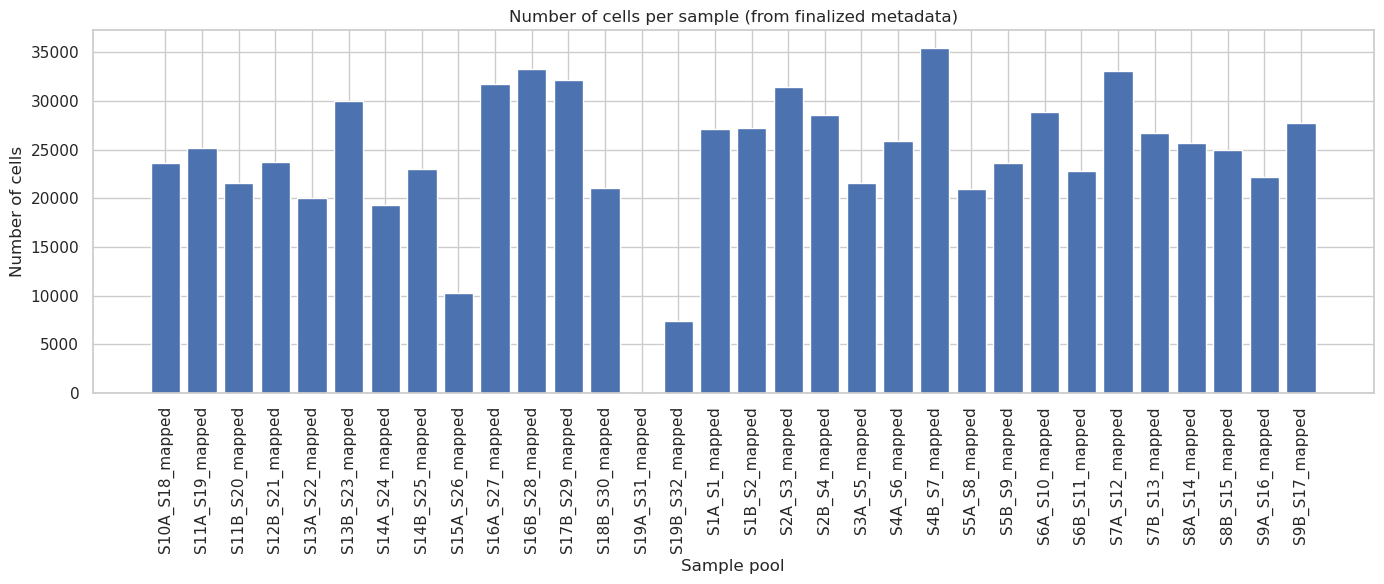

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the metadata
metadata_path = "/rds/general/user/pr422/projects/puklandmarkproject/live/Users/Parisa/ephemeral_files/Parisa_scdownstream/output_full/run3_celltypist_new_model/finalized/merged_metadata.csv"
df = pd.read_csv(metadata_path)

# Count number of cells per sample
cell_counts = df['sample'].value_counts().sort_index()

# Plot
plt.figure(figsize=(14, 6))
bars = plt.bar(cell_counts.index, cell_counts.values)
plt.xticks(rotation=90, ha='center')  # ensure center alignment
plt.ylabel("Number of cells")
plt.xlabel("Sample pool")
plt.title("Number of cells per sample (from finalized metadata)")
plt.tight_layout()
plt.show()

In [19]:
plt.savefig("/rds/general/user/pr422/projects/puklandmarkproject/live/Users/Parisa/ephemeral_files/Parisa_scdownstream/output_full/run3_celltypist_new_model/finalized/cell_counts_per_sample.png", dpi=300)  # You can also use .pdf or .svg

plt.show()

<Figure size 640x480 with 0 Axes>

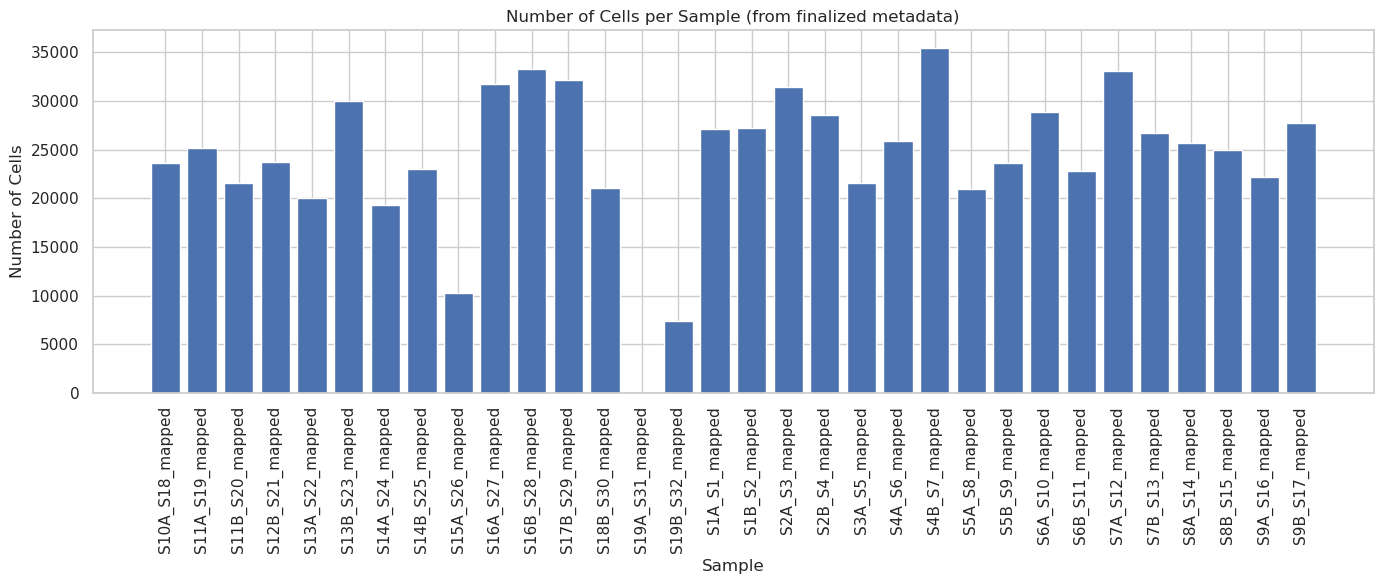

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.bar(cell_counts.index, cell_counts.values)
plt.xticks(rotation=90, ha='center')
plt.ylabel("Number of Cells")
plt.xlabel("Sample")
plt.title("Number of Cells per Sample (from finalized metadata)")
plt.tight_layout()

# Save as PNG and PDF
plt.savefig("/rds/general/user/pr422/projects/puklandmarkproject/live/Users/Parisa/ephemeral_files/Parisa_scdownstream/output_full/run3_celltypist_new_model/finalized/cell_counts_per_sample.png", dpi=300)
plt.savefig("/rds/general/user/pr422/projects/puklandmarkproject/live/Users/Parisa/ephemeral_files/Parisa_scdownstream/output_full/run3_celltypist_new_model/finalized/cell_counts_per_sample.pdf")  # <- PDF version

plt.show()

/rds/general/user/pr422/ephemeral/ipykernel_2661587/3167658013.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=6)


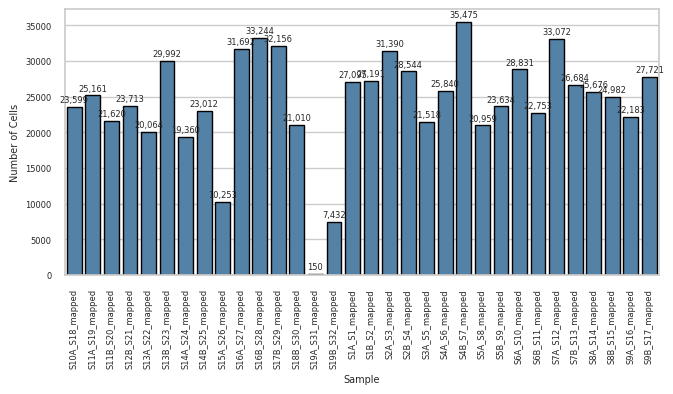

In [43]:
# Alex script
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the metadata CSV
metadata = pd.read_csv("/rds/general/user/pr422/projects/puklandmarkproject/live/Users/Parisa/ephemeral_files/Parisa_scdownstream/output_full/run3_celltypist_new_model/finalized/merged_metadata.csv")  # Update the path as needed

# Count cells per sample
cell_counts = metadata['sample'].value_counts().sort_index()

# Set up the figure size (in inches)
fig, ax = plt.subplots(figsize=(6.8, 4))  # <7 inch width

# Set seaborn style
sns.set(style="whitegrid", font_scale=0.7)  # ~7pt font

# Create barplot
bars = sns.barplot(x=cell_counts.index, y=cell_counts.values, color="steelblue", edgecolor="black", ax=ax)

# Annotate bars with the cell count
for i, val in enumerate(cell_counts.values):
    ax.text(i, val + max(cell_counts.values) * 0.01, f'{val:,}', 
            ha='center', va='bottom', fontsize=6)

# Rotate x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=6)
ax.set_ylabel("Number of Cells", fontsize=7)
ax.set_xlabel("Sample", fontsize=7)
ax.tick_params(axis='y', labelsize=6)

# Tight layout for better spacing
plt.tight_layout()
plt.savefig("/rds/general/user/pr422/projects/puklandmarkproject/live/Users/Parisa/ephemeral_files/Parisa_scdownstream/output_full/run3_celltypist_new_model/finalized/cell_counts_per_sample.pdf", format='pdf', dpi=300)
plt.show() 

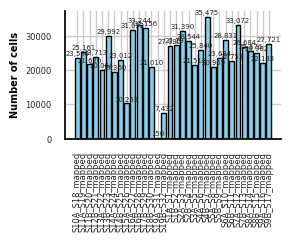

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Load metadata
metadata_path = "/rds/general/user/pr422/projects/puklandmarkproject/live/Users/Parisa/ephemeral_files/Parisa_scdownstream/output_full/run3_celltypist_new_model/finalized/merged_metadata.csv"
metadata = pd.read_csv(metadata_path)

# Count cells per sample
cell_counts = metadata['sample'].value_counts().sort_index()

# Create bar chart
fig, ax = plt.subplots(figsize=(3, 2.5))  # match width=3, height=2.5 inches

bars = ax.bar(cell_counts.index, cell_counts.values, color='skyblue', edgecolor='black', width=0.8)

# Add count labels on top of bars
for i, val in enumerate(cell_counts.values):
    ax.text(i, val + max(cell_counts.values) * 0.01, f'{val:,}', 
            ha='center', va='bottom', fontsize=5)

# Style adjustments to mimic ggplot theme_classic()
ax.set_ylabel("Number of cells", fontsize=7, fontweight='bold')
ax.set_xticks(range(len(cell_counts)))
ax.set_xticklabels(cell_counts.index, rotation=90, fontsize=6)
ax.tick_params(axis='y', labelsize=6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.yaxis.label.set_color('black')

# Tight layout and save
plt.tight_layout()
plt.savefig("/rds/general/user/pr422/projects/puklandmarkproject/live/Users/Parisa/ephemeral_files/Parisa_scdownstream/output_full/run3_celltypist_new_model/finalized/cell_counts_per_sample.pdf", format='pdf', dpi=300)
plt.show() 

In [ ]:
plt.savefig("/rds/general/user/pr422/projects/puklandmarkproject/live/Users/Parisa/ephemeral_files/Parisa_scdownstream/output_full/run3_celltypist_new_model/finalized/cell_counts_per_sample.pdf", format='pdf', dpi=300)

<Figure size 640x480 with 0 Axes>